# Creando estructura YOLO

In [1]:
def convert_yolo(box, size=(117, 926)):
    dw = 1./size[1]
    dh = 1./size[0]
    x = (box[0] + box[2])/2.0
    y = (box[1] + box[3])/2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [2]:
import os,shutil
import json
from pathlib import Path
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%capture
!unzip /content/drive/MyDrive/DatasetMusica/dataset.zip

In [5]:
%mkdir datasetYOLO
%mkdir datasetYOLO/train
%mkdir datasetYOLO/test

- Creando las imágenes

In [6]:
carpetas=['train/','test/']
path_o='dataset/'
path_t='datasetYOLO/'
for dir in carpetas:
  for file in os.listdir(path_o+dir+'images'):
    original = path_o+dir
    target = path_t+dir
    stem=Path(file).stem
    shutil.move(original+'images/'+file,target+file)

- Creando las anotaciones

In [7]:
d={'claved':0, 'claves':1, 'clavef':2, 'nota1':3, 'nota2':4, 'nota4':5, 'nota1:2':6, 'nota1:4':7, 'notae':8, 'sos':9, 'bem':10, 'bec':11, 'sil0':12, 'sil1':13, 'sil2':14, 'sil1:2':15, 'sil1:4':16, '2x4':17, '3x4':18, '4x4':19, '6x8':20, 'punt':21, 'liga':22,'3':23,'line':24,'P2':25, 'nota1:8':26, 'cal':27, '3x2':28,'mf':29,'P1':30,'check':31,'3x8':32,'2x2':33}
carpetas=['train/','test/']
path_o='dataset/'
path_t='datasetYOLO/'
for dir in carpetas:
  for file in os.listdir(path_o+dir+'annotations'):
    original = path_o+dir
    target = path_t+dir
    a = json.load(open(original+'annotations/'+file))
    b = open(target+file[:-4]+'txt','w')
    for coords in a:
      x,y,w,h = convert_yolo(coords['box'])
      label = d[coords['label']]
      b.write(str(label) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + '\n')
    b.close()

- Creando el train.txt y test.txt

In [8]:
image_files = []
os.chdir(os.path.join("datasetYOLO","test"))
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".jpg"):
        image_files.append("datasetYOLO/test/" + filename)
os.chdir("..")
with open("test.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()
os.chdir("..")

In [9]:
image_files = []
os.chdir(os.path.join("datasetYOLO","train"))
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".jpg"):
        image_files.append("datasetYOLO/train/" + filename)
os.chdir("..")
with open("train.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()
os.chdir("..")

- Creando el classes.names

In [11]:
d = {a:b for b,a in d.items()}
with open('datasetYOLO/classes.txt','w') as f:
  for i in range(0,34):
    f.write(d[i]+'\n')

- Guardando en drive

In [27]:
import shutil
shutil.make_archive('/content/datasetYOLO','zip','/content/datasetYOLO')

'/content/datasetYOLO.zip'

# Entrenando 

In [12]:
%%capture
!git clone https://github.com/AlexeyAB/darknet
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!/usr/local/cuda/bin/nvcc --version
!make
!apt-get install tree

In [13]:
%%capture
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [21]:
!tree /content/datasetYOLO -L 1 -C

/content/datasetYOLO
├── classes.names
├── test
├── test.txt
├── train
└── train.txt

2 directories, 3 files


In [23]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def mostrarImagen(imagePath):
  image = cv2.imread(imagePath)
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    fig, ax = plt.subplots(1,1,figsize=(16,5))
    ax.imshow(img2,cmap=plt.cm.binary)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.show()
  else:
    img2 = image
    fig, ax = plt.subplots(1,1,figsize=(16,5))
    ax.imshow(img2,cmap=plt.cm.binary)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.show()

def mostrarImagenConAnotacion(imagePath,annotationPath,classesPath):
    image = cv2.imread(imagePath)
    (H,W)=image.shape[:2]
    with open(annotationPath) as f:
        lines = f.readlines()
    with open(classesPath) as f:
        clases = f.readlines()
    for annot in lines:
        (c,x,y,w,h) = annot.split(' ')
        cv2.rectangle(image,(int((float(x)-float(w)/2)*W),int((float(y)-float(h)/2)*H)),(int((float(x)+float(w)/2)*W),int((float(y)+float(h)/2)*H)),(0,255,0),10)
        cv2.putText(image,clases[int(c)],(int((float(x)-float(w)/2)*W),int((float(y)-float(h)/2)*H-2)),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)
    img2 = image[:,:,::-1]
    fig, ax = plt.subplots(1,1,figsize=(16,5))
    ax.imshow(img2,cmap=plt.cm.binary)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.show()

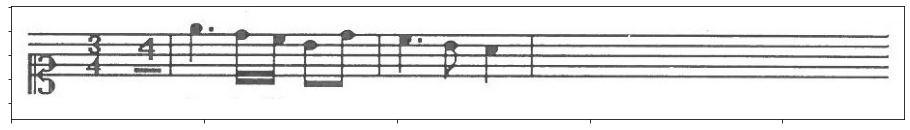

In [24]:
mostrarImagen('/content/datasetYOLO/train/pent1001.jpg')

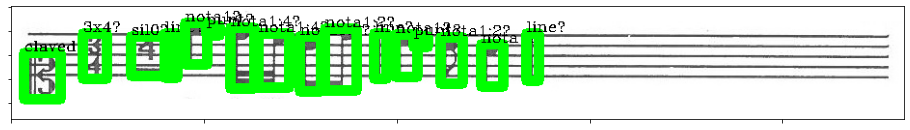

In [25]:
mostrarImagenConAnotacion('/content/datasetYOLO/train/pent1001.jpg','/content/datasetYOLO/train/pent1001.txt','/content/datasetYOLO/classes.names')

In [26]:
!cat /content/datasetYOLO/classes.names

claved
claves
clavef
nota1
nota2
nota4
nota1:2
nota1:4
notae
sos
bem
bec
sil0
sil1
sil2
sil1:2
sil1:4
2x4
3x4
4x4
6x8
punt
liga
3
line
P2
nota1:8
cal
3x2
mf
P1
check
3x8
2x2

In [ ]:
#!cat celldataset/train.txt

In [ ]:
#!cat celldataset/train.cfg

In [ ]:
!cat celldataset/classes.data

classes = 1
train  = /content/darknet/celldataset/train.txt
valid  = /content/darknet/celldataset/test.txt
names = /content/darknet/celldataset/classes.names
backup = /content/darknet/backup

In [ ]:
%%capture
!./darknet detector train celldataset/classes.data celldataset/train.cfg yolov4.conv.137 -dont_show

In [ ]:
%%capture
!./darknet detector test celldataset/classes.data celldataset/test.cfg backup/train_last.weights celldataset/train/images/eu-001-2-4.jpg

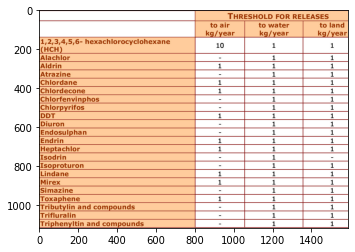

In [ ]:
mostrarImagen('predictions.jpg')